In [0]:
import numpy as np
import pandas as pd
import string
import re
import nltk
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas_profiling
import requests 
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download
nltk.download('punkt')
import pickle
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
#we are going to use a kaggle text file that contains encodings of english words 
!pip install -U -q kaggle
!mkdir -p ~/.kaggle


In [0]:
#import your kaggle API key in order to load the kaggle file for words tokens processing (english ones) and the train.csv and test.csv
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# connecting to kaggle using your API
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets list

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
gustavomodelli/forest-fires-in-brazil                    Forest Fires in Brazil                              31KB  2019-08-24 16:09:16          17403  
rajeevw/ufcdata                                          UFC-Fight historical data from 1993 to 2019          3MB  2019-07-05 09:58:02          12394  
tristan581/17k-apple-app-store-strategy-games            17K Mobile Strategy Games                            8MB  2019-08-26 08:22:16          13955  
chirin/africa-economic-banking-and-systemic-crisis-data  Africa Economic, Banking and Systemic Crisis Data   14KB  2019-07-21 02:00:17           6378  
akhilv11/border-crossing-entry-data                      Border Crossing Entry Data     

In [0]:
#downloading the proper file, it is zipped so we'll need to unzip it
!kaggle datasets download -d terenceliu4444/glove6b100dtxt/data#
!ls

100% 131M/131M [00:02<00:00, 40.3MB/s]
100% 131M/131M [00:02<00:00, 51.5MB/s]
glove6b100dtxt.zip  kaggle.json  sample_data  test.csv	train.csv


In [0]:
#unzipping it
!unzip /content/glove6b100dtxt.zip

Archive:  /content/glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [0]:
# reading and checking our data
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

In [0]:
# we will use this later on to create the submission.csv file
test_TweetId = test['TweetId'].values

In [0]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [0]:
train.describe().T
test.describe().T

,count,mean,std,min,25%,50%,75%,max
TweetId,2610.0,2.803202e+17,6.844036e+16,2.320824e+09,2.941447e+17,3.017323e+17,3.056284e+17,3.068337e+17


In [0]:
#this is gives an in-depth profile report on our data (training set)
pandas_profiling.ProfileReport(train)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,3
Number of observations,6525
Total Missing (%),0.0%
Total size in memory,153.1 KiB
Average record size in memory,24.0 B
Numeric,1
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


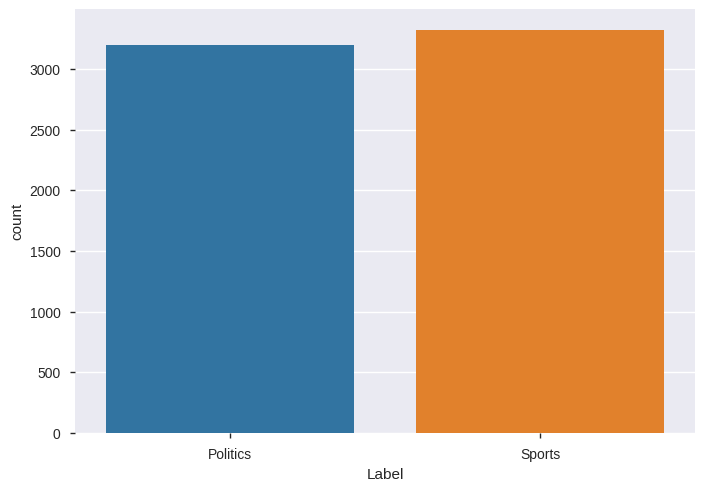

In [0]:
# visualizing our labels by number of tweets
import seaborn as sns

sns.countplot(x='Label', data=train)

In [0]:
train.drop('TweetId',axis = 1,inplace = True)
test.drop('TweetId',axis = 1,inplace = True)

In [0]:
#remove the user handles (@user)
train['TweetText'] = train['TweetText'].str.replace("@", "") 
test['TweetText'] = test['TweetText'].str.replace("@", "") 
train.head()

,Label,TweetText
0,Politics,SecKerry The value of the StateDept and USA...
1,Politics,rraina I fear so
2,Sports,Watch video highlights of the wwc final be...
3,Sports,RT chelscanlan At Nitro Circus at AlbertPar...
4,Sports,cricketfox Always a good thing Thanks for th...


In [0]:
#removing links
train['TweetText'] = train['TweetText'].str.replace(r"http\S+", "") 
test['TweetText'] = test['TweetText'].str.replace(r"http\S+", "") 
train.head()

,Label,TweetText
0,Politics,SecKerry The value of the StateDept and USA...
1,Politics,rraina I fear so
2,Sports,Watch video highlights of the wwc final be...
3,Sports,RT chelscanlan At Nitro Circus at AlbertPar...
4,Sports,cricketfox Always a good thing Thanks for th...


In [0]:
#removing special characters
train['TweetText'] = train['TweetText'].str.replace("[^a-zA-Z]", " ")
test['TweetText'] = test['TweetText'].str.replace("[^a-zA-Z]", " ")
train.head()

,Label,TweetText
0,Politics,SecKerry The value of the StateDept and USA...
1,Politics,rraina I fear so
2,Sports,Watch video highlights of the wwc final be...
3,Sports,RT chelscanlan At Nitro Circus at AlbertPar...
4,Sports,cricketfox Always a good thing Thanks for th...


In [0]:
#creating our stopwords to remove what isnt meaningful
stopwords=nltk.corpus.stopwords.words('english')

In [0]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [0]:
train['TweetText'] = train['TweetText'].apply(lambda text : remove_stopwords(text.lower()))
test['TweetText'] = test['TweetText'].apply(lambda text : remove_stopwords(text.lower()))

In [0]:
#writing function that removes punctuation (making sure its all clean and good to go)
def remove_punctuation(text):
    no_punc="".join ([x for x in text if x not in string.punctuation])
    return no_punc

In [0]:
#removing punctuation and appending that column to a new one
train['TextNoPunc'] = train['TweetText'].apply( lambda x: remove_punctuation(x))
test['TextNoPunc'] = test['TweetText'].apply( lambda x: remove_punctuation(x))
train['TextNoPunc'].head()

0    seckerry value statedept usaid measured dollar...
1                                          rraina fear
2    watch video highlights wwc final australia wes...
3    rt chelscanlan nitro circus albertpark theymak...
4         cricketfox always good thing thanks feedback
Name: TextNoPunc, dtype: object

In [0]:
#using keras word tokenizer to seperate each words of the sentences included in the column, also adding it to a new column as well
train['TextToken'] = train['TextNoPunc'].apply(word_tokenize)
test['TextToken'] = test['TextNoPunc'].apply(word_tokenize)

In [0]:
#we can see the properly cleaned and tokenized tweets now
train['TextToken'].head()

0    [seckerry, value, statedept, usaid, measured, ...
1                                       [rraina, fear]
2    [watch, video, highlights, wwc, final, austral...
3    [rt, chelscanlan, nitro, circus, albertpark, t...
4    [cricketfox, always, good, thing, thanks, feed...
Name: TextToken, dtype: object

In [0]:
#setting up our Label as the y
y = train['Label']
y = np.array(list(map(lambda x: 1 if x=="Politics" else 0, y)))
train_label = train['Label'].values

In [0]:
#i prefered training and testing on the train dataset to have a better accuracy
X_train, X_test, y_train, y_test = train_test_split(train['TextToken'].values, y, test_size=0.20, random_state=42)

In [0]:
#now we tokenize our words again, from keras preprocessing module to create a word to index dictionnary, hence the usage of the kaggle text file
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
#now we find vocabulary size and then perform padding on both train and test set (the test set here is still 10% of the training one).
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
#we use glove embeddings 6B 100d to get our global vectors for word representation
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [0]:
# now we create an embedding matrix where each row number will correspond to the index of the word in the corpus
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1101800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,166,057
Trainable params: 64,257
Non-trainable params: 1,101,800
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)



Train on 4176 samples, validate on 1044 samples
Epoch 1/6
4176/4176 [==============================] - 16s 4ms/step - loss: 0.3182 - acc: 0.8676 - val_loss: 0.2045 - val_acc: 0.9061
Epoch 2/6
4176/4176 [==============================] - 16s 4ms/step - loss: 0.1865 - acc: 0.9253 - val_loss: 0.1922 - val_acc: 0.9090
Epoch 3/6
4176/4176 [==============================] - 15s 4ms/step - loss: 0.1497 - acc: 0.9428 - val_loss: 0.1855 - val_acc: 0.9148
Epoch 4/6
4176/4176 [==============================] - 15s 4ms/step - loss: 0.1253 - acc: 0.9564 - val_loss: 0.1820 - val_acc: 0.9167
Epoch 5/6
4176/4176 [==============================] - 15s 4ms/step - loss: 0.1035 - acc: 0.9674 - val_loss: 0.1818 - val_acc: 0.9100
Epoch 6/6
1305/1305 [==============================] - 2s 1ms/step


In [0]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.1633854128620177
Test Accuracy: 0.9210727964324513


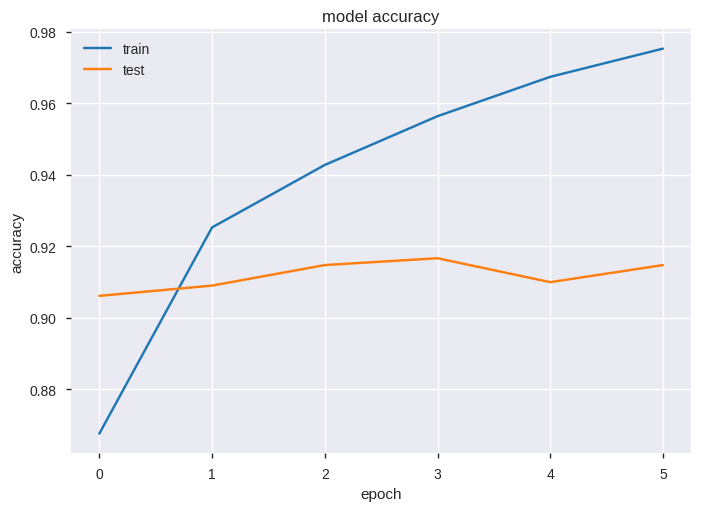

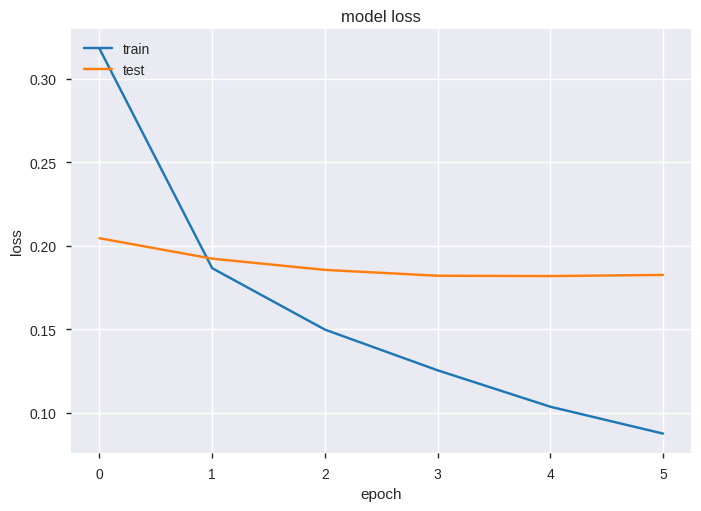

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
X_newtest = test['TextToken'].values

In [0]:
X_newtest = tokenizer.texts_to_sequences(X_newtest)
X_newtest = pad_sequences(X_newtest, padding='post', maxlen=maxlen)

In [0]:
prediction = model.predict(X_newtest,batch_size=128, verbose=1 )

2610/2610 [==============================] - 3s 1ms/step


In [0]:
prediction = np.array(list(map(lambda x: "Politics" if x>=0.5 else "Sports", prediction)))

In [0]:
submission = {
    'TweetId': test_TweetId,
    'Label': prediction
}
solution = pd.DataFrame(submission)
solution.head()
solution.to_csv("submission.csv",index=False)